<a href="https://colab.research.google.com/github/atomikkus/vcf_filteration/blob/main/VCFs_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.simplefilter(action='ignore')
import pandas as pd
import numpy as np
import os
import glob2
import re
import progressbar
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

path= "/content/drive/MyDrive/GBC/s_filtered/" #Importing all csv files of samples

Mounted at /content/drive


In [ ]:
files= glob2.glob(os.path.join(path, "*.csv"))
ce_files = []
abs_files =[]

for i in files:
  if '-SE8-' in i or '-SSE-' in i or 'SSE' in i or 'SE8' in i or '-B-' in i:
    abs_files.append(i)
  else:
    ce_files.append(i)

In [ ]:
ce_files = abs_files

In [ ]:
ce_files

['/content/drive/MyDrive/GBC/s_filtered/VIHE-F-SE8-CL-S79-S1-L001_filtered.csv',
 '/content/drive/MyDrive/GBC/s_filtered/VIAC-F-SE8-S12_filtered.csv',
 '/content/drive/MyDrive/GBC/s_filtered/VI2C-F2-SE8-CL-RES-S8_filtered.csv',
 '/content/drive/MyDrive/GBC/s_filtered/VIBK-F-SE8-S20_filtered.csv',
 '/content/drive/MyDrive/GBC/s_filtered/WB2H-F-Res-D-SE8-S3_filtered.csv',
 '/content/drive/MyDrive/GBC/s_filtered/WCUF-F-Res-D-SE8-CL-S218-L004_filtered.csv',
 '/content/drive/MyDrive/GBC/s_filtered/VIWA-Z-SE8-CL-RES-S16_filtered.csv',
 '/content/drive/MyDrive/GBC/s_filtered/VLSA-F-Res-D-L2-SE8-S5_filtered.csv',
 '/content/drive/MyDrive/GBC/s_filtered/VIWB-Z2-SE8-CL-RES-S29-L002-S1-L001_filtered.csv',
 '/content/drive/MyDrive/GBC/s_filtered/WEVQ-F-Res-D-SE8-CL-S37_filtered.csv',
 '/content/drive/MyDrive/GBC/s_filtered/WDFF-F1F2-Res-D-L2-SE8-CL_filtered.csv',
 '/content/drive/MyDrive/GBC/s_filtered/WE4R-F1F2-Res-D-L2-SE8-CL_filtered.csv',
 '/content/drive/MyDrive/GBC/s_filtered/WCUG-F-Res-D-SE

In [ ]:
# mkdir /content/drive/MyDrive/GBC/s_filtered

In [ ]:

for i in progressbar.progressbar(range(len(ce_files))):
  df = pd.read_csv(ce_files[i]).drop_duplicates('IGV_link')
  sp1=re.split(r'/|\\',ce_files[i])[-1]
  col_n=sp1.split('_')[0]
  df[f'{col_n}:DP'] = df[f'{col_n}:DP'].replace('.', '0').astype('float')
  df = df[df['FILTER']=='PASS']

  ## Pop frequency
  columns_to_process = ['esp6500siv2_all', 'ExAC_ALL', 'ExAC_SAS', 'AF', 'AF_sas', '1000g2015aug_all', '1000g2015aug_all', '1000g2015aug_SAS', 'Ref_Depth']

  for column in columns_to_process:
    df[column] = df[column].replace('.', '0').astype('float')

  df = df[df['esp6500siv2_all']<= 0.01]
  df = df[df['ExAC_ALL']<= 0.01]
  df = df[df['ExAC_SAS']<= 0.01]
  df = df[df['AF']<=0.01]
  df = df[df['AF_sas']<= 0.01]
  df = df[df['1000g2015aug_all']<= 0.01]
  df = df[df['1000g2015aug_all']<= 0.01]
  df = df[df['1000g2015aug_SAS']<= 0.01]
  df = df[df['Ref_Depth']>=2]
  df = df[df['ExonicFunc.ensGene']!='synonymous SNV']
  df = df[~df['InterVar_automated'].str.contains('benign', case=False)]
  df.to_csv(f'/content/drive/MyDrive/GBC/s_filtered/{col_n}_filtered.csv', index=False)


100% (22 of 22) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


## Compose the binary file

In [ ]:
my_df=[]



for i in progressbar.progressbar(range(len(ce_files))):
  df = pd.read_csv(ce_files[i]).drop_duplicates()
  sp1=re.split(r'/|\\',ce_files[i])[-1]
  col_n=sp1.split('_')[0]
  row_list=df['Ref.Gene'].tolist()
  col_list=df['InterVar_automated'].tolist()
  new_df=pd.DataFrame(col_list,index=row_list,columns=[col_n])
  new_df=new_df.replace("Uncertain_significance","1")
  new_df=new_df.replace("Uncertain_significance","1")
  new_df=new_df.replace("Benign","2")
  new_df=new_df.replace("Likely_benign","3")
  new_df=new_df.replace("Likely_pathogenic","5")
  new_df=new_df.replace('Pathogenic',"6")
  new_df=new_df.replace('.','4')
  new_df=new_df.astype(int)
  mod_df = new_df.copy()
  mod_df[new_df > 4] = 1 # Pathogenic
  mod_df[(new_df <= 4) & (new_df > 0)] = 1 #Benign
  mod_df.fillna(0, inplace=True)
  mod_df = mod_df.groupby(mod_df.index.tolist(),axis=0)
  grouped_df=mod_df.sum()
  my_df.append(grouped_df)

100% (22 of 22) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


In [ ]:
fdf = pd.concat(my_df, axis=1).fillna(0).T
fdf.sum().sum()

14510.0

In [ ]:
fdf = pd.concat(my_df, axis=1).fillna(0).T
fdf = fdf.apply(lambda x: x.apply(lambda y: 1 if y > 0 else 0))

def fbc_rename(x):
  return 'IN-423-'+x.split('-')[0]
new_indexes = []
for i in fdf.index.to_list():
  new_indexes.append(fbc_rename(i))

fdf.set_index(pd.Index(new_indexes), inplace=True)

fdf.drop_duplicates(inplace=True)

In [ ]:
fdf

,AAK1,ABCA13,ABCB8,ABCF1,ABCG1,ABHD1,ABR,ACAA1,ACBD4,ACOT1,...,WIPI2,XPR1,YARS2,ZCCHC2,ZFPM2,ZNF471,ZNF529,ZNF547,ZNF549,ZNF775
IN-423-VIHE,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
IN-423-VIAC,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
IN-423-VI2C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
IN-423-VIBK,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
IN-423-WB2H,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
IN-423-WCUF,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
IN-423-VIWA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
IN-423-VLSA,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
IN-423-VIWB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
IN-423-WEVQ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
freq_df = fdf.sum(axis=0).reset_index()
freq_df.columns  = ['Gene', 'Frequency']

In [ ]:
freq_df.sort_values('Frequency', ascending=False).to_csv('GBC_gene_freq.csv')

<Axes: >

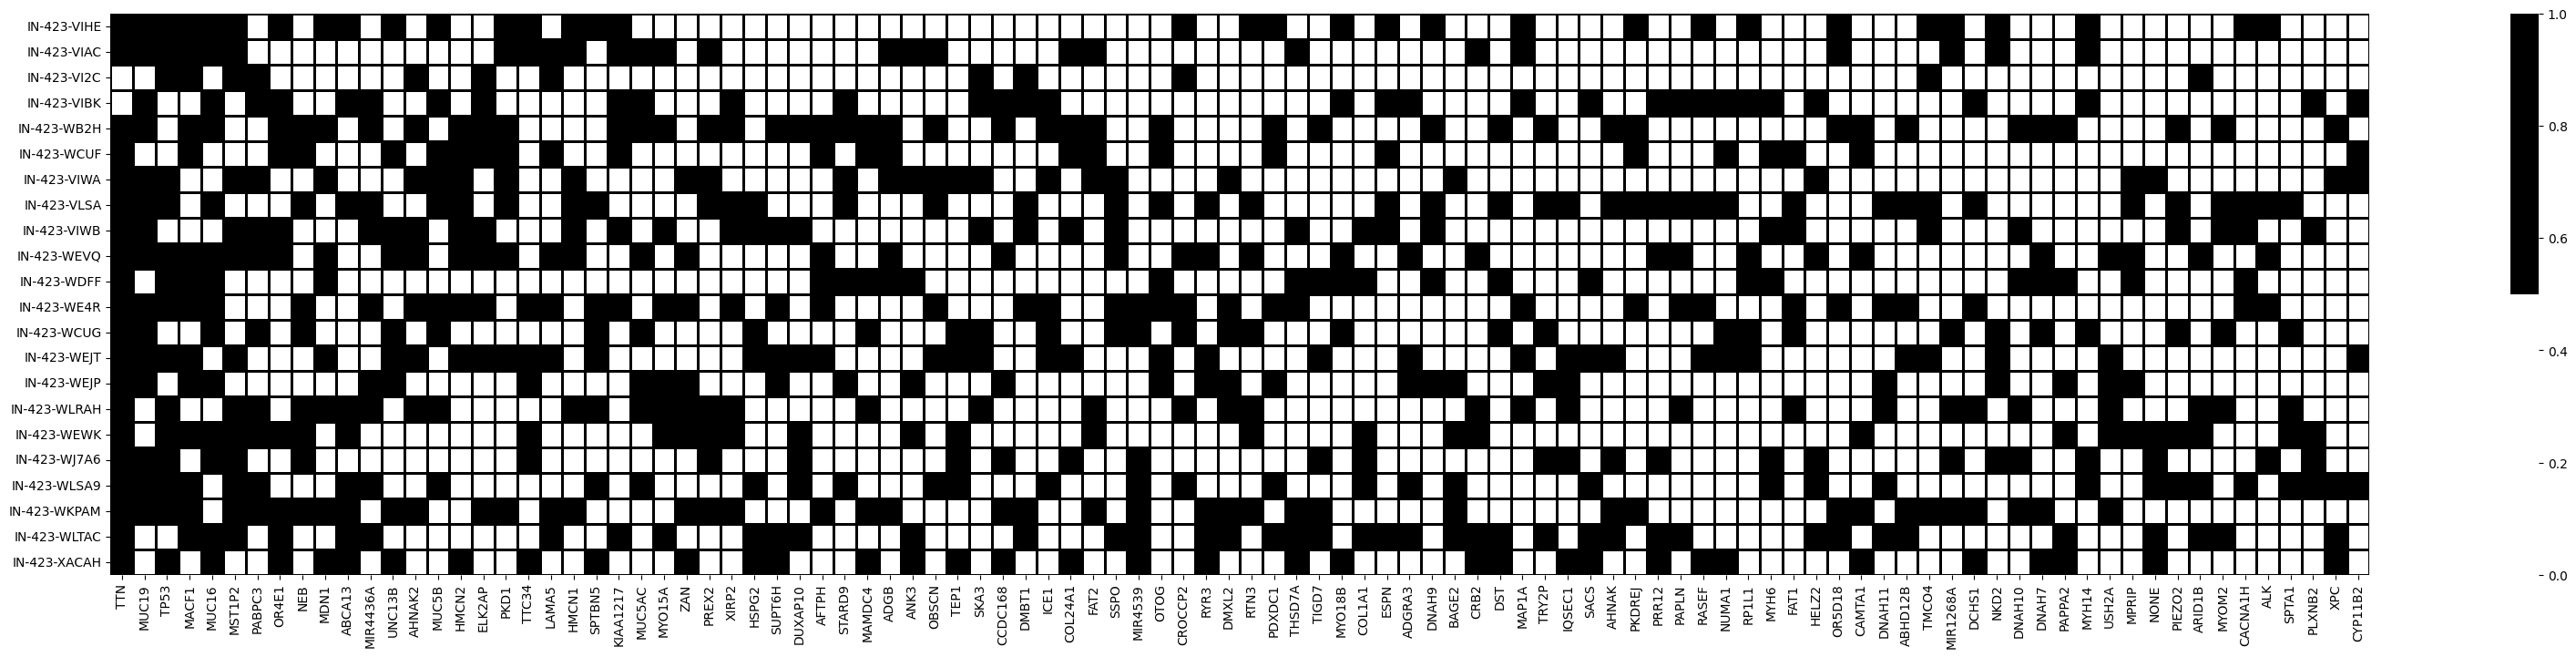

In [ ]:
plt.figure(figsize=(40, 8))
custom_bw_palette = ['#FFFFFF','#000000']

# Set the custom palette in Seaborn
x=sns.color_palette(custom_bw_palette)

sns.heatmap(fdf[freq_df.sort_values('Frequency', ascending=False).head(100)['Gene'].to_list()], cmap=x, linewidths=1, linecolor='black')


In [ ]:
freq_df.sort_values('Frequency', ascending=False).head(100)['Gene'].to_list()

['.',
 'AGAP10P',
 'BAGE2',
 'TPTE',
 'POTEG',
 'CROCCP2',
 'OR2L13',
 'NONE',
 'MUC5AC',
 'MUC19',
 'MST1P2',
 'MIR4436A',
 'MIR3675',
 'DUXAP10',
 'LOC390705',
 'LOC107985911',
 'ANKRD30BP2',
 'LOC101927429',
 'GYPA',
 'FAM74A1',
 'GGT3P',
 'LOC101927050',
 'LINC00999',
 'FAM30C',
 'LOC100996724',
 'LOC105370697',
 'LINC02297',
 'ZNF141',
 'TIMM23B-AGAP6',
 'NBPF1',
 'LINC02203',
 'DDX12P',
 'LOC101926935',
 'LOC283683',
 'ECE1',
 'RAB6C',
 'TTN',
 'GOLGA8CP',
 'LOC285074',
 'LOC440292',
 'TCAF2P1',
 'CHEK2P2',
 'CLCNKA',
 'POTEM',
 'NANOGP8',
 'PABPC3',
 'HGC6.3',
 'HSFY1P1',
 'GOLGA6A',
 'NCF1B',
 'MIR10396A',
 'FAM90A25P',
 'FAM90A7P',
 'PRIM2',
 'ZNF267',
 'GOLGA6L3',
 'FANK1',
 'LILRB4',
 'CLK4',
 'RRBP1',
 'PRB4',
 'CROCC',
 'BCR',
 'TNXB',
 'ENPP7P13',
 'TBC1D3P2',
 'FAM66E',
 'MUC2',
 'LYZL2',
 'DRD5P2',
 'IVL',
 'ACTR3BP2',
 'SLC35G4',
 'TBC1D3P1-DHX40P1',
 'FAM66A',
 'RP1L1',
 'PRAMEF8',
 'POTEH',
 'FKBP9P1',
 'LNP1',
 'PABPC1',
 'OR8G5',
 'ZC3H11B',
 'KRT18',
 'SEC63',
 'N

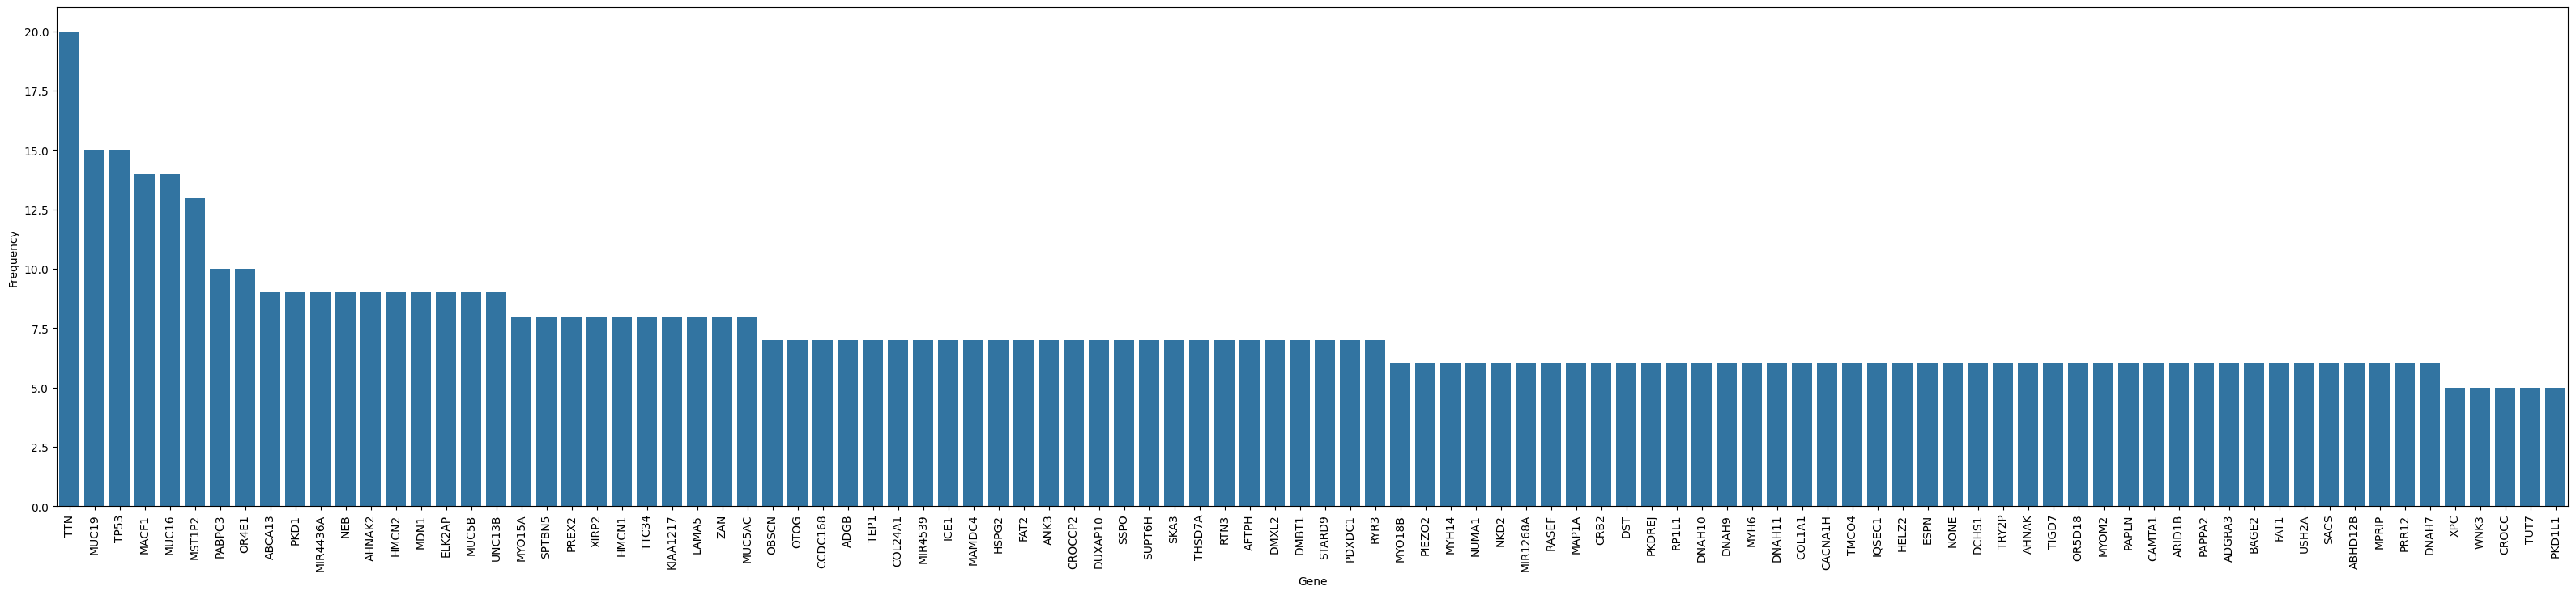

In [ ]:
plt.figure(figsize=(40, 8))
sns.barplot(freq_df.sort_values('Frequency', ascending=False).head(100), x='Gene', y='Frequency')
var = plt.xticks(rotation=90)

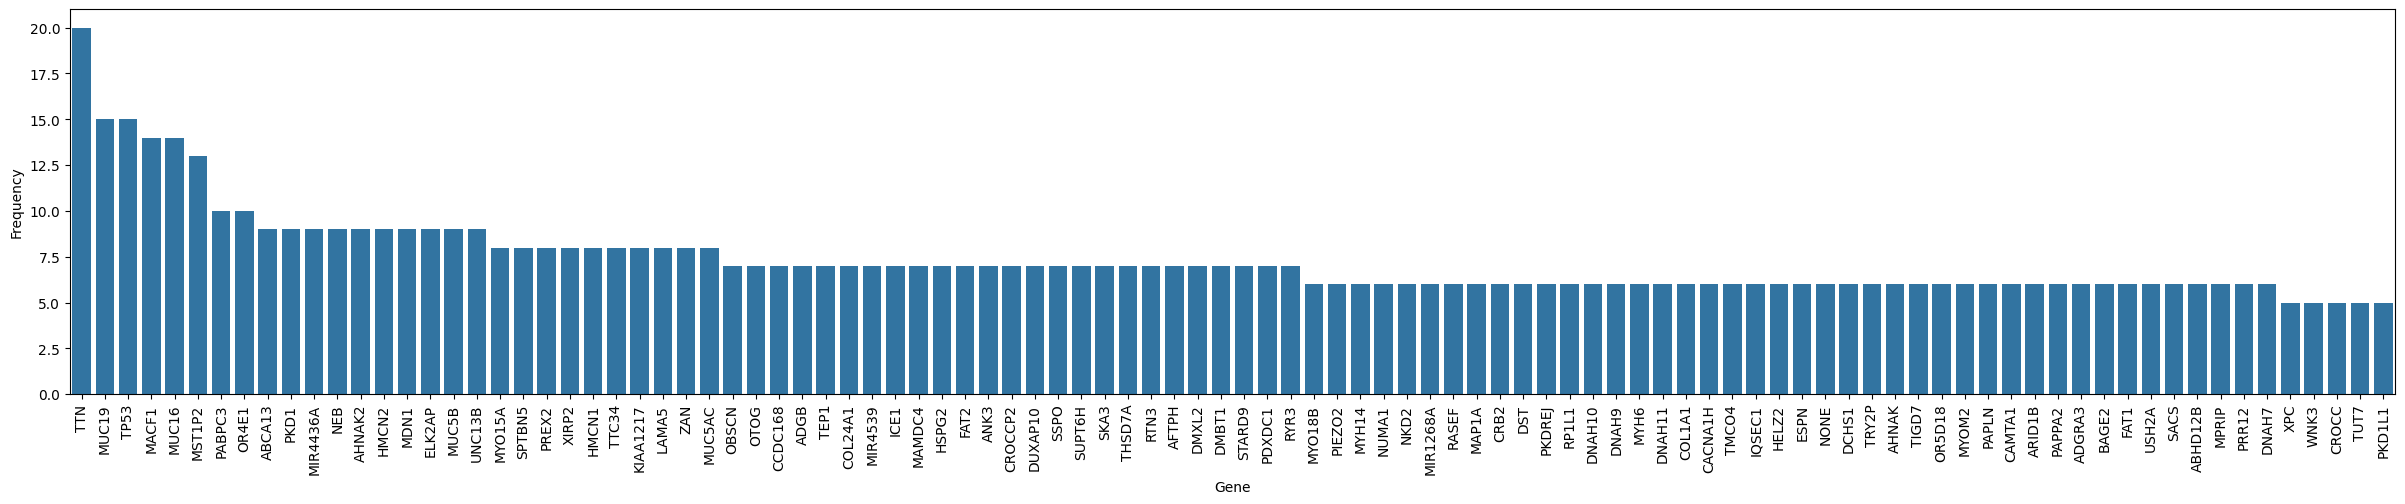

In [ ]:
## Gene frequency within Dataset

result_dict = {}
for index, row in fdf.iterrows():
    genes_list = row[row == 1].index.tolist()
    result_dict[index] = genes_list

gene_frequency = {}
for genes_list in result_dict.values():
    for gene in genes_list:
        if gene in gene_frequency:
            gene_frequency[gene] += 1
        else:
            gene_frequency[gene] = 1

gf =pd.DataFrame(list(gene_frequency.items()), columns=['Gene', 'Frequency']).sort_values('Frequency', ascending=False).iloc[:100, :]
gf.to_csv('gene_freq_WC_cancer.csv')
plt.figure(figsize=(30, 5))
sns.barplot(gf, x='Gene', y='Frequency')
var = plt.xticks(rotation=90)